# Set up Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL

import tensorflow as tf
from tensorflow import _keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential

from src import evaluation

# Dataset exploration

In [2]:
# We set de dataset folder direction
data_dir = r'C:\Users\pct3x\OneDrive\Documentos\Proyectos Independientes\COVID_DET_X_RAY\dataset'
data_dir = data_dir.replace('\\', '/')
data_dir

'C:/Users/pct3x/OneDrive/Documentos/Proyectos Independientes/COVID_DET_X_RAY/dataset'

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/pct3x/OneDrive/Documentos/Proyectos Independientes/COVID_DET_X_RAY/dataset')

In [4]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

94


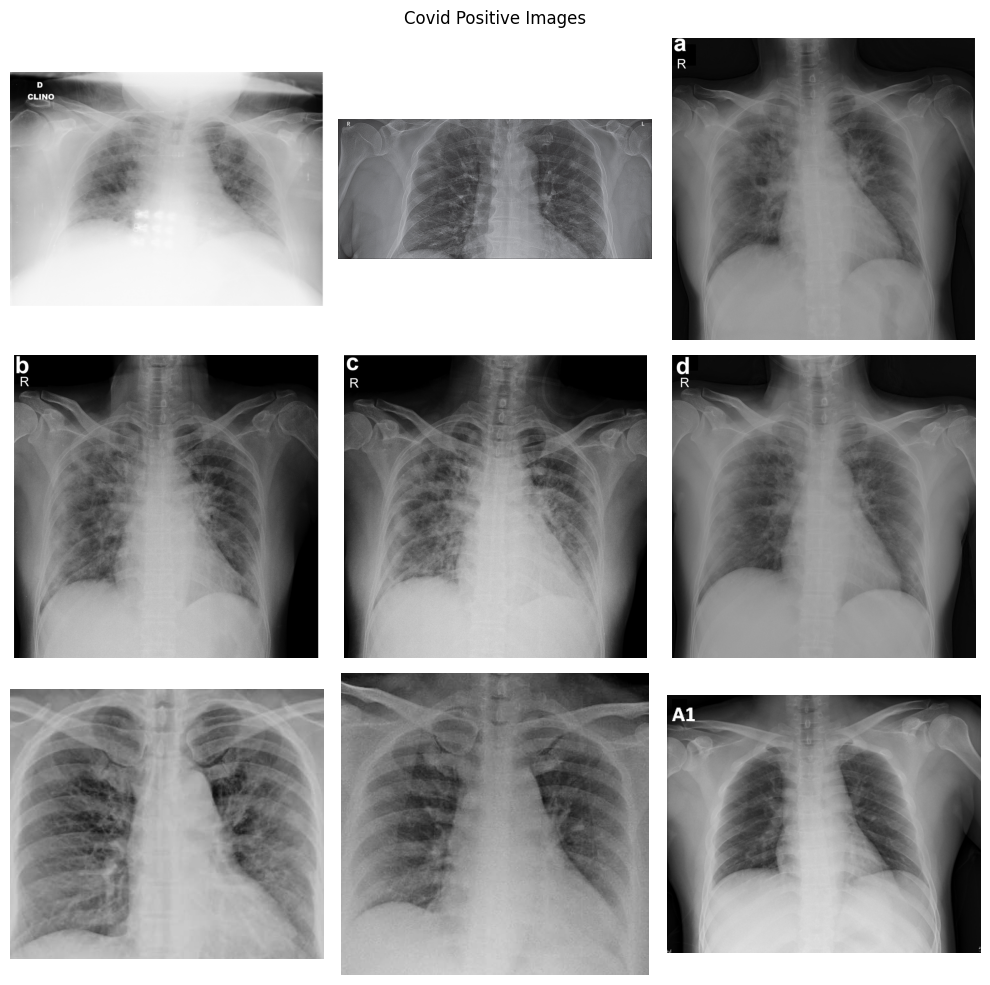

In [5]:
covids = list(data_dir.glob('covid/*'))
fig, axs = plt.subplots(3,3, figsize=(10,10))

for i in range(9):
    img = PIL.Image.open(str(covids[i]))

    row = i // 3
    col = i % 3

    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].axis('off')

fig.suptitle('Covid Positive Images')
plt.tight_layout()
plt.show()

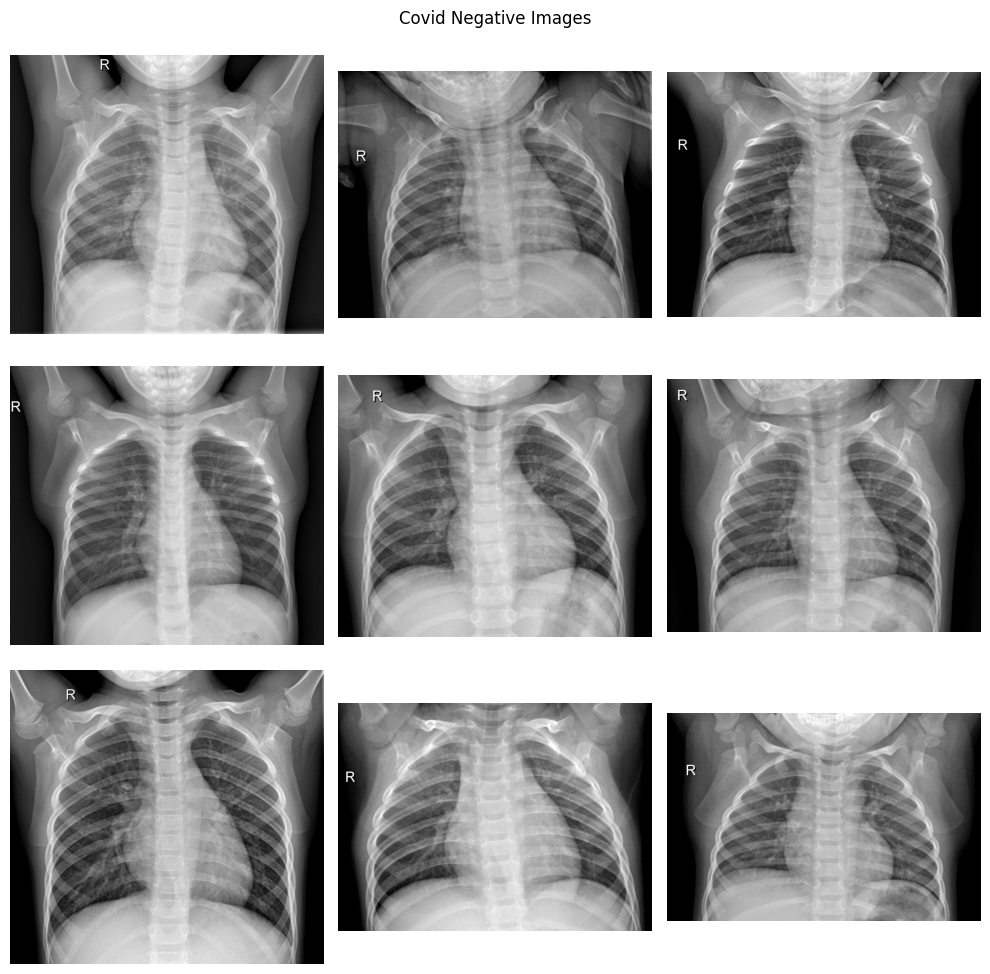

In [6]:
normals = list(data_dir.glob('normal/*'))
fig, axs = plt.subplots(3,3, figsize=(10,10))

for i in range(9):
    img = PIL.Image.open(str(normals[i]))

    row = i // 3
    col = i % 3

    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].axis('off')

fig.suptitle('Covid Negative Images')
plt.tight_layout()
plt.show()

# Create Dataset

In [7]:
batch_size = 20
img_height = 224
img_width = 224

In [8]:
print(94*0.7)
print(94*0.15)

65.8
14.1


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 94 files belonging to 2 classes.
Using 76 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 94 files belonging to 2 classes.
Using 18 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['covid', 'normal']


In [12]:
Autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=Autotune)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=Autotune)

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)

(20, 224, 224, 3)
(20, 2)
(16, 224, 224, 3)
(16, 2)
(20, 224, 224, 3)
(20, 2)
(20, 224, 224, 3)
(20, 2)


In [14]:
y_test = np.empty((0,2))
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    y_aux = labels_batch.numpy()
    y_test = np.concatenate((y_test, y_aux), axis=0)

(18, 224, 224, 3)
(18, 2)


In [15]:
y_test.shape

(18, 2)

# Model Creation

In [16]:
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras import layers
from tensorflow import keras

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

In [17]:
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape, include_preprocessing=True)

base_model.trainable = False

inputs = keras.Input(shape=input_shape)

x = base_model(inputs, training = False)

y = keras.layers.Flatten()(x)

outputs = layers.Dense(num_classes, activation = 'softmax')(y)

my_model = keras.Model(inputs, outputs)

my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 2)                 125442    
                                                                 
Total params: 117,872,290
Trainable params: 125,442
Non-trainable params: 117,746,848
_________________________________________________________________


# First Fitting of Model.
If it overfits we're ok and will have to make it more generalized.

In [18]:
my_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=5e-2),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

In [19]:
history1 = my_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
4/4 [==============================] - 77s 11s/step - loss: 47.3026 - accuracy: 0.7105 - val_loss: 29.8473 - val_accuracy: 0.9444
Epoch 2/5
4/4 [==============================] - 33s 9s/step - loss: 36.9640 - accuracy: 0.9079 - val_loss: 29.8205 - val_accuracy: 0.8889
Epoch 3/5
4/4 [==============================] - 30s 8s/step - loss: 0.9727 - accuracy: 0.9737 - val_loss: 74.2334 - val_accuracy: 0.9444
Epoch 4/5
4/4 [==============================] - 29s 8s/step - loss: 5.2444 - accuracy: 0.9737 - val_loss: 99.6491 - val_accuracy: 0.9444
Epoch 5/5
4/4 [==============================] - 29s 8s/step - loss: 2.8312 - accuracy: 0.9868 - val_loss: 97.9125 - val_accuracy: 0.9444


Overfits but not so much.

In [20]:
y_pred = my_model.predict(val_ds)

1/1 [==============================] - 13s 13s/step


In [21]:
y_pred.shape

(18, 2)

In [22]:
y_pred

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [23]:
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [24]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    y_pred[:,0], y_test[:,0]
)

Model Performance metrics:
------------------------------
Accuracy: 0.9444444444444444
Precision: 0.9230769230769231
Recall: 1.0
F1 Score: 0.9600000000000001

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           0       1.00      0.83      0.91         6

    accuracy                           0.94        18
   macro avg       0.96      0.92      0.93        18
weighted avg       0.95      0.94      0.94        18


Prediction Confusion Matrix:
------------------------------
    0  1
0  12  0
1   1  5


1/1 [==============================] - 6s 6s/step


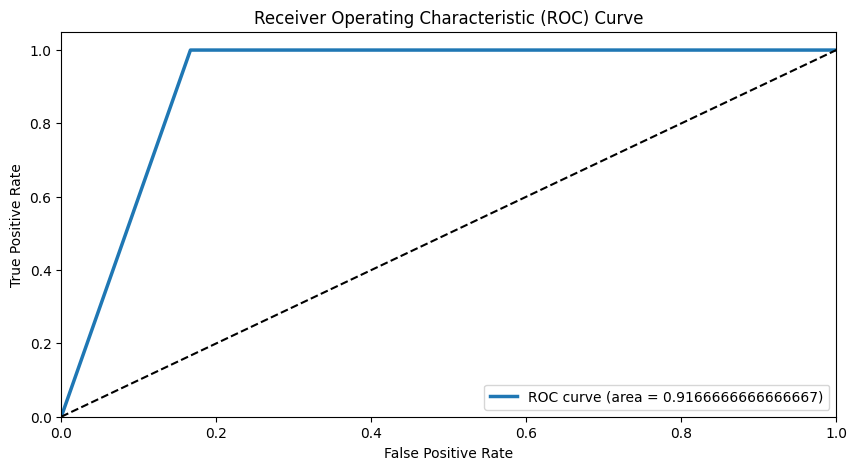

0.9166666666666667

In [25]:
evaluation.plot_roc(my_model, y_test[:,0], val_ds)

In [26]:
from tensorflow.keras.regularizers import l2

In [27]:
z = layers.Dropout(0.9)(y)

outputs = layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=l2(0.05))(z)

my_model2 = keras.Model(inputs, outputs)

my_model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 


 dense_1 (Dense)             (None, 2)                 125442    
                                                                 
Total params: 117,872,290
Trainable params: 125,442
Non-trainable params: 117,746,848
_________________________________________________________________


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
my_model2.compile(
    optimizer = keras.optimizers.Adam(learning_rate=5e-2),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

checkpoint_callback = ModelCheckpoint(filepath='best_model/best_my_model.h5', monitor='val_accuracy', save_best_only=True)

In [30]:
history2 = my_model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=9,
    callbacks=[checkpoint_callback]
)

Epoch 1/9
4/4 [==============================] - 79s 12s/step - loss: 38.7843 - accuracy: 0.7500 - val_loss: 76.2993 - val_accuracy: 0.9444
Epoch 2/9
4/4 [==============================] - 27s 8s/step - loss: 90.7671 - accuracy: 0.9342 - val_loss: 119.9413 - val_accuracy: 0.9444
Epoch 3/9
4/4 [==============================] - 28s 7s/step - loss: 112.7865 - accuracy: 0.9868 - val_loss: 142.2955 - val_accuracy: 0.9444
Epoch 4/9
4/4 [==============================] - 27s 7s/step - loss: 117.3836 - accuracy: 0.9737 - val_loss: 132.6872 - val_accuracy: 0.9444
Epoch 5/9
4/4 [==============================] - 27s 7s/step - loss: 102.3588 - accuracy: 0.9868 - val_loss: 106.5193 - val_accuracy: 0.9444
Epoch 6/9
4/4 [==============================] - 27s 7s/step - loss: 82.4727 - accuracy: 0.9737 - val_loss: 86.7883 - val_accuracy: 0.9444
Epoch 7/9
4/4 [==============================] - 28s 7s/step - loss: 65.4385 - accuracy: 0.9868 - val_loss: 83.0664 - val_accuracy: 0.8889
Epoch 8/9
4/4 [====

In [31]:
y_pred2 = my_model2.predict(val_ds)
y_pred2

1/1 [==============================] - 13s 13s/step


array([[0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.1899691e-30, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [32]:
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [35]:
threshold = 0.5
y_pred2_binary = [1 if p >= threshold else 0 for p in y_pred2[:,0]]

In [37]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    y_pred2_binary, y_test[:,0]
)

Model Performance metrics:
------------------------------
Accuracy: 0.9444444444444444
Precision: 0.9230769230769231
Recall: 1.0
F1 Score: 0.9600000000000001

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           0       1.00      0.83      0.91         6

    accuracy                           0.94        18
   macro avg       0.96      0.92      0.93        18
weighted avg       0.95      0.94      0.94        18


Prediction Confusion Matrix:
------------------------------
    0  1
0  12  0
1   1  5


1/1 [==============================] - 5s 5s/step


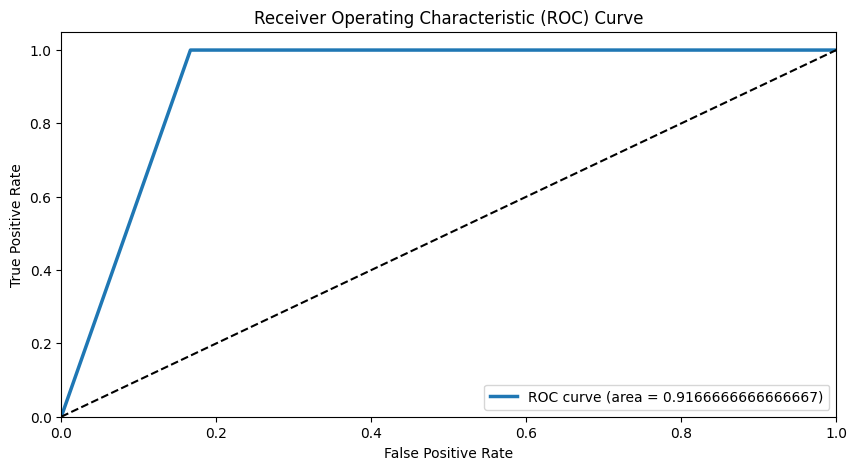

0.9166666666666667

In [38]:
evaluation.plot_roc(my_model2, y_test[:,0], val_ds)